## showing effect of pcs or peers on long range correlations
for both PEER factors and global PCs
* longer range chromosome correlations being removed with more pcs or peers (boxplot by gene distance decile)
* visualizations of across chr corr structure as pcs or peers are removed
    * with outlining of clusters
* line graph showing fraction of short vs long corrs that are signifigant

In [4]:
# import packages
import numpy as np
import pandas as pd
import pyranges as pr
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import spearmanr, linregress
import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
import scipy as sp
from matplotlib.colors import LinearSegmentedColormap
from sklearn.decomposition import PCA



from residualize import calculate_residual

In [6]:
# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/pcqtl_allgenes.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

tissue_id_path = config['tissue_id_path']
clusters_dir = config['clusters_dir']
expression_dir = config['expression_dir']
covariates_dir = config['covariates_dir']

# load in the tissue ids 
tissue_df = pd.read_csv(f"{prefix}/{tissue_id_path}", header=0)
tissue_ids = list(tissue_df['Tissue'])
tissue_id = 'Lung'

### load in data

expression and covariates

In [7]:
# load in gene expression data
expression_df_full = pd.read_csv(f'{prefix}/{expression_dir}/{tissue_id}.v8.normalized_expression.bed', sep='\t')
# load in covariates
covariates_df = pd.read_csv(f'{prefix}/{covariates_dir}/{tissue_id}.v8.covariates.txt', sep='\t', index_col=0).T
# make sure the genes are in the same order in both
expression_df = expression_df_full.set_index('gene_id')[covariates_df.index]

In [47]:
# load in the gene information (for gene-gene distances)
full_gencode=pd.read_csv('/home/klawren/oak/pcqtls/data/references/processed_gencode.v26.GRCh38.genes.gtf', sep='\t', skiprows=range(6), 
            header=None, names=['chr', 'dataset', 'type', 'start','end', '.', 'strand', 'na', 'info'])

full_gencode = full_gencode[full_gencode['type']=='transcript']
full_gencode['transcript_id'] = full_gencode['info'].str.split(';').str[1].str.split('\"').str[-2]
full_gencode['gene_name'] = full_gencode['info'].str.split(';').str[3].str.split('\"').str[-2]

full_gencode['gene_type'] = full_gencode['info'].str.split(';').str[2].str.split('\"').str[-2]
full_gencode['tss_start'] = np.where(full_gencode['strand'] == '+', full_gencode['start'], full_gencode['end'])


gid_gencode = full_gencode.set_index('transcript_id').loc[expression_df.index]
gid_gencode = gid_gencode.drop_duplicates()

In [9]:
# function to residualize expression based on two covariate dfs
def two_part_residualize(expression_df, base_covariates_df, additional_covariates_df):
    full_covariates = pd.concat([base_covariates_df, additional_covariates_df], axis=1)
    # residulize the expression 
    residal_exp = calculate_residual(expression_df[full_covariates.index], full_covariates, center=True)
    residal_exp = pd.DataFrame(residal_exp, columns=full_covariates.index, index=expression_df.index)
    return residal_exp

In [10]:
# split out covatiates
base_covariates_df = covariates_df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'pcr', 'platform', 'sex']]
peer_covariates_df = covariates_df[[f'InferredCov{i}' for i in range(1,61,1)]]

In [49]:
# get the genes from chr22 to plot
chr21_gene_ids = gid_gencode[gid_gencode['chr'] == 'chr21'].index.values
chr21_gene_names = gid_gencode[gid_gencode['chr'] == 'chr21']['gene_name']

## peers

* boxplot by gene distance decile
* heatmap of correlation
    * with cluster outlines

In [12]:
# by decile of gene-gene distance

# matrix of gene-gene distances
start_positions = gid_gencode.loc[chr21_gene_ids]['tss_start'].values
dist_matrix = np.abs(start_positions[:, None] - start_positions)

# Create deciles based on distance 
deciles = np.percentile(dist_matrix, [10, 20, 30, 40, 50, 60, 70, 80, 90])
decile_df = pd.DataFrame(np.digitize(dist_matrix, deciles), index=chr21_gene_ids, columns=chr21_gene_ids)

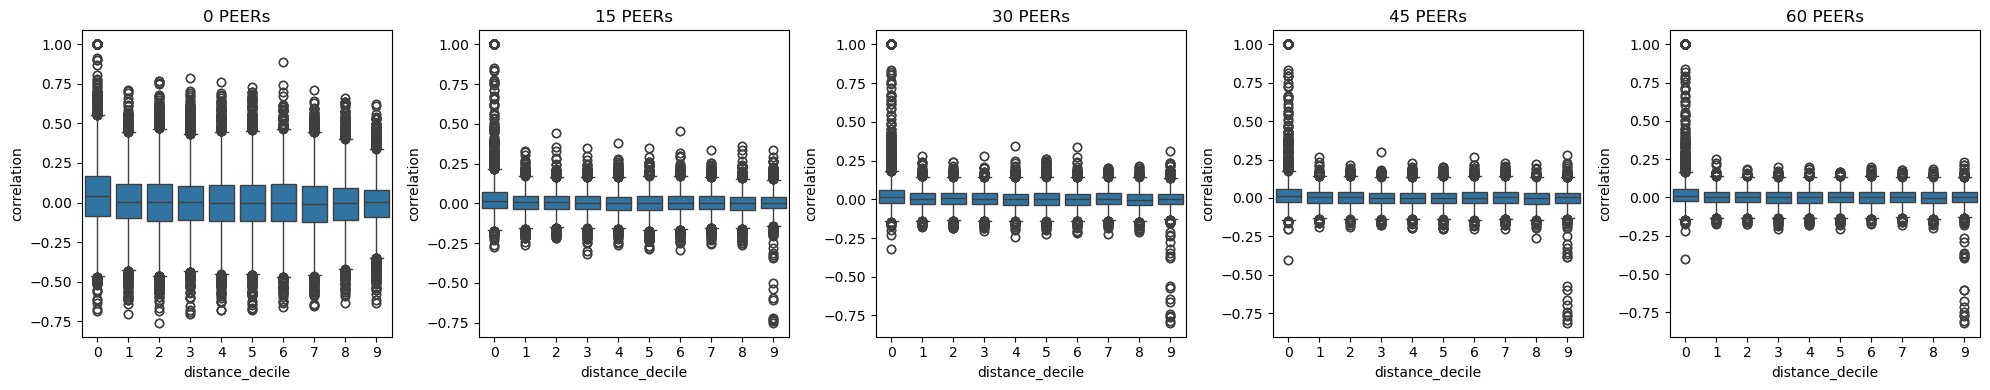

In [13]:
# boxplots plots by increaseing peer factor count

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    axes[i].set_title(f'{15*i} PEERs')

    # get corr with this many peerspeer_covariates_df
    sub_exp = two_part_residualize(expression_df, base_covariates_df, peer_covariates_df.iloc[:, :15*i])
    sub_corr = sub_exp.loc[chr21_gene_ids].T.corr(method='spearman')
    distance_split_corr_df = pd.DataFrame([pd.Series(sub_corr.values[decile_df==i], name=i) for i in range(10)]).T.melt(var_name='distance_decile', value_name='correlation')
    sns.boxplot(distance_split_corr_df, y='correlation', x='distance_decile', ax=axes[i])

fig.tight_layout()

In [32]:
def plot_heatmap_corr(corr, ax, cbar=True, tick_labels=False):
    # plot a heat map of correlations for increasing number of peer factors

    # mask so the off diagonal isn't shown
    mask = np.triu(np.ones_like(corr)) 
    # create the colormap, these are colors matched to the manhattenplots. coolwarm is another good option
    cmap = LinearSegmentedColormap.from_list('mycmap', [(0, '#c4553aff'), (.5, 'white'), (1, '#3e8093ff')])
    # plot the correlations
    sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, ax=ax, cbar_kws={'label':'Spearman Corrleation', 'pad':0}, xticklabels=True, yticklabels=True, cbar=cbar)

    if not tick_labels:
        ax.tick_params(left=False, bottom=False)
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    # no axis labels
    ax.set_ylabel('')
    ax.set_xlabel('')

    return ax

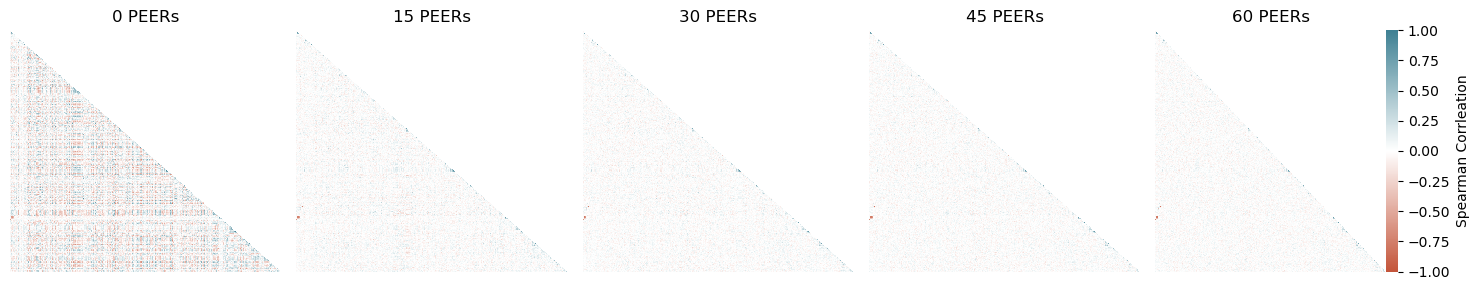

In [32]:
# correlation plots by increaseing peer factor count

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axes[i].set_title(f'{15*i} PEERs')

    # get corr with this many peerspeer_covariates_df
    sub_exp = two_part_residualize(expression_df, base_covariates_df, peer_covariates_df.iloc[:, :15*i])
    sub_corr = sub_exp.loc[chr21_gene_ids].T.corr(method='spearman')
    plot_heatmap_corr(sub_corr, axes[i], cbar=True if i==4 else False)


fig.tight_layout()


In [21]:
# add cluster outlines to heatmap
clusters_df = pd.read_csv(f'{prefix}/data/processed/allgenes_rewrite/clusters/{tissue_id}_clusters_all_chr.csv', index_col=0)
clusters_df = clusters_df[clusters_df['Chromosome'] == 21]

clusters_df_tami = pd.read_csv(f'{prefix}/data/processed/allgenes/clusters_tami/{tissue_id}_clusters_all_chr.csv', index_col=0)
clusters_df_tami = clusters_df_tami[clusters_df_tami['Chromosome'] == 21]

In [50]:
# corr with all 60 peers removed
final_residual_exp = two_part_residualize(expression_df, base_covariates_df, peer_covariates_df)
final_residual_corr, final_residual_pvalue = spearmanr(final_residual_exp.loc[chr21_gene_ids], axis=1)

# make into df
final_residual_corr_df = pd.DataFrame(final_residual_corr, index=chr21_gene_names, columns=chr21_gene_names)

# calculate total number of pairs considered for bonferroni correction
total_pairs = 0
max_cluster_size=50
for i in np.arange(1,23,1):
    chr_gene_ids = expression_df_full[expression_df_full['#chr'] == f'chr{i}']['gene_id']
    upper_corner_idxs = np.triu(np.ones(len(chr_gene_ids)), k=1)
    excluded_cluster_size_idxs = np.triu(np.ones(len(chr_gene_ids)), k=max_cluster_size)
    total_pairs += upper_corner_idxs.sum()  - excluded_cluster_size_idxs.sum()


# a version with non-signifigant correlations blanked out
final_residual_corr_masked = final_residual_corr.copy()
final_residual_corr_masked[final_residual_pvalue >= (.05/total_pairs)] = 0
final_residual_corr_masked_df = pd.DataFrame(final_residual_corr_masked, index=chr21_gene_names, columns=chr21_gene_names)


In [53]:
# just expression on this chr
chr21_expression = final_residual_exp.loc[chr21_gene_ids].reset_index()

fig, ax = plt.subplots(figsize=(100,100))
ax = plot_heatmap_corr(final_residual_corr_df, ax, tick_labels=True)

# plot my clusters
for idx, row in clusters_df.iterrows():
    # location of this cluster in the expression df
    cluster_idxs = chr21_expression[chr21_expression['gene_id'].isin(row['Transcripts'].split(','))].index.values
    # vertical line part
    ax.plot([cluster_idxs[-1]+1,cluster_idxs[-1]+1],[cluster_idxs[0],cluster_idxs[-1]+1],  color='k', linewidth=4)
    ax.plot([cluster_idxs[0],cluster_idxs[0]], [cluster_idxs[0],cluster_idxs[-1]+1], color='k', linewidth=4)
    # horizontal line part
    ax.plot([cluster_idxs[0],cluster_idxs[-1]+1], [cluster_idxs[-1]+1,cluster_idxs[-1]+1], color='k', linewidth=4)
    ax.plot([cluster_idxs[0],cluster_idxs[-1]+1], [cluster_idxs[0],cluster_idxs[0]], color='k', linewidth=4)


# plot tami's clusters
for idx, row in clusters_df_tami.iterrows():
    # location of this cluster in the expression df
    cluster_idxs = chr21_expression[chr21_expression['gene_id'].isin(row['Transcripts'].split(','))].index.values
    # vertical line part
    ax.plot([cluster_idxs[-1]+1,cluster_idxs[-1]+1],[cluster_idxs[0],cluster_idxs[-1]+1],  color='r', linewidth=2)
    ax.plot([cluster_idxs[0],cluster_idxs[0]], [cluster_idxs[0],cluster_idxs[-1]+1], color='r', linewidth=2)
    # horizontal line part
    ax.plot([cluster_idxs[0],cluster_idxs[-1]+1], [cluster_idxs[-1]+1,cluster_idxs[-1]+1], color='r', linewidth=2)
    ax.plot([cluster_idxs[0],cluster_idxs[-1]+1], [cluster_idxs[0],cluster_idxs[0]], color='r', linewidth=2)


## Global PCs

* boxplot by gene distance decile
* heatmap of correlation

In [67]:
# get pc covariantes (these will be cacluated after the genotype pc and other base covars are residualized)

base_residual_expression = calculate_residual(expression_df[base_covariates_df.index], base_covariates_df, center=True)
base_residual_expression = pd.DataFrame(base_residual_expression, columns=base_covariates_df.index, index=expression_df.index)

# get global pcs 
pca = PCA()
global_pc_values = pca.fit_transform(base_residual_expression.T)
pc_covariates_df = pd.DataFrame(global_pc_values, index=covariates_df.index, columns=[f'PC{i}' for i in range(global_pc_values.shape[0])])


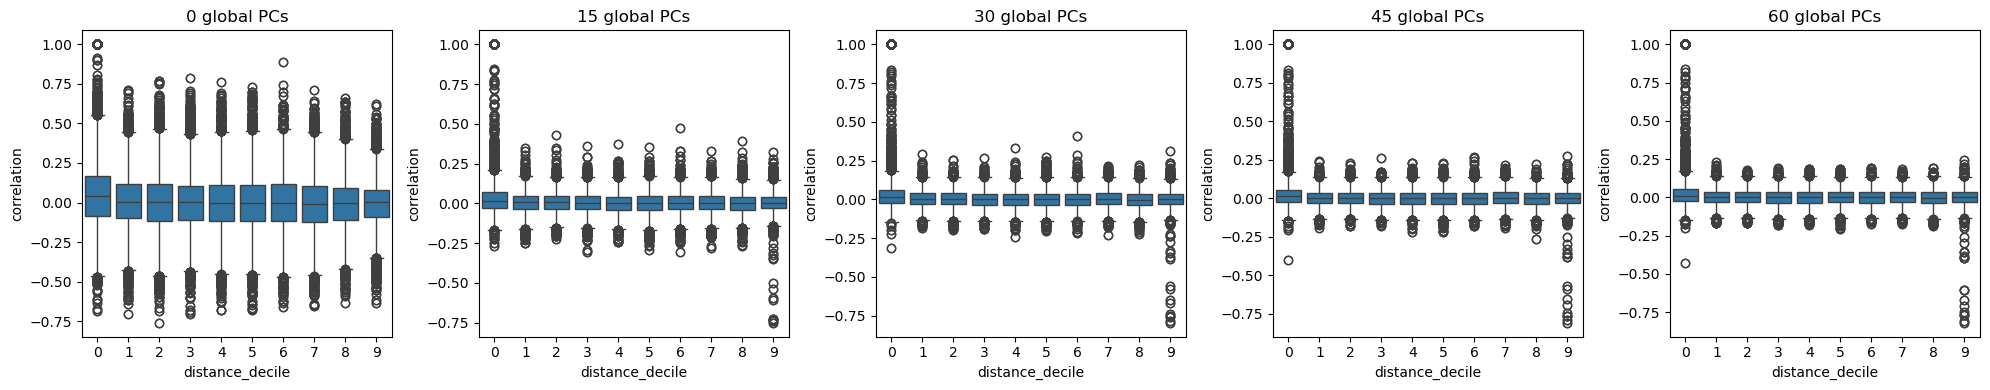

In [78]:
# boxplots plots by increaseing peer factor count

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    axes[i].set_title(f'{15*i} global PCs')

    # get corr with this many peerspeer_covariates_df
    sub_exp = two_part_residualize(expression_df, base_covariates_df, pc_covariates_df.iloc[:, :15*i])
    sub_corr = sub_exp.loc[chr21_gene_ids].T.corr(method='spearman')
    distance_split_corr_df = pd.DataFrame([pd.Series(sub_corr.values[decile_df==i], name=i) for i in range(10)]).T.melt(var_name='distance_decile', value_name='correlation')
    sns.boxplot(distance_split_corr_df, y='correlation', x='distance_decile', ax=axes[i])

fig.tight_layout()

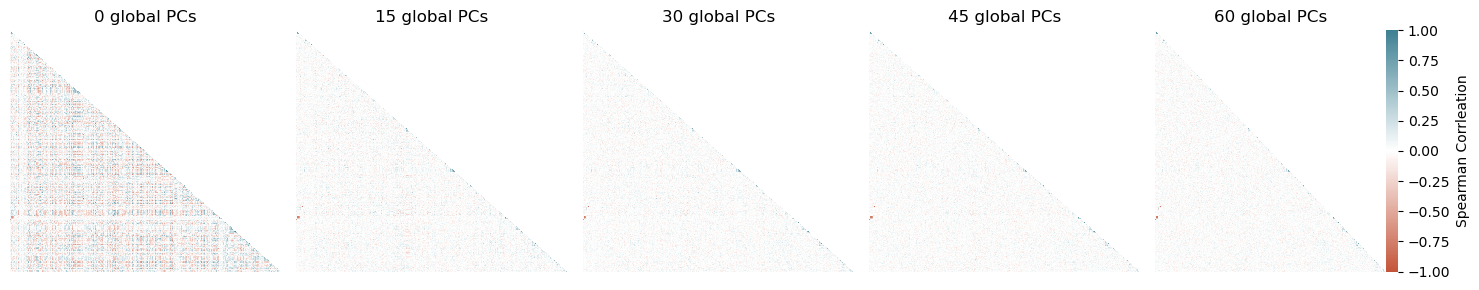

In [77]:
# correlation plots by increaseing global pc factor count

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axes[i].set_title(f'{15*i} global PCs')

    # get corr with this many global pcs residualized
    sub_exp = two_part_residualize(expression_df, base_covariates_df, pc_covariates_df.iloc[:, :15*i])
    sub_corr = sub_exp.loc[chr21_gene_ids].T.corr(method='spearman')
    plot_heatmap_corr(sub_corr, axes[i], cbar=True if i==4 else False)


fig.tight_layout()


Suggested that maybe I need to do some pre-filtering to determine only variable genes to include in global pcs. This maybe isn't worth the time

## PCs vs PEERs
* at what point global pcs and peers start removing local structure

In [140]:
fraction_close_sig_pc = []
fraction_far_sig_pc = []

fraction_close_sig_peer = []
fraction_far_sig_peer = []

for i in range(60):
    # expression residualized with some pcs
    sub_exp = two_part_residualize(expression_df, base_covariates_df, pc_covariates_df.iloc[:, :i])
    pc_residual_corr, pc_residual_pvalue = spearmanr(sub_exp.loc[chr21_gene_ids], axis=1)
    np.fill_diagonal(pc_residual_pvalue, np.NAN)

    # signifigant corrs along the diagonal or 1-2 away
    #close_pvals = np.concatenate([np.diagonal(residual_pvalue, i) for i in range(1, 3, 1)])
    close_pvals = pc_residual_pvalue[decile_df<2]
    fraction_close_sig_pc.append(sum(close_pvals < (.05/total_pairs))/len(close_pvals))

    # signifigant corrs off the diagonal
    #far_pvals = residual_pvalue[np.triu_indices(len(residual_pvalue), k=3)]
    far_pvals = pc_residual_pvalue[decile_df>8]
    fraction_far_sig_pc.append(((far_pvals < (.05/total_pairs))/len(far_pvals)).sum())

    # expression residualized with some peers
    sub_exp = two_part_residualize(expression_df, base_covariates_df, peer_covariates_df.iloc[:, :i])
    peer_residual_corr, peer_residual_pvalue = spearmanr(sub_exp.loc[chr21_gene_ids], axis=1)

    # signifigant corrs along the diagonal or 1-2 away
    #close_pvals = np.concatenate([np.diagonal(peer_residual_pvalue, i) for i in range(1, 3, 1)])
    close_pvals = peer_residual_pvalue[decile_df<2]
    fraction_close_sig_peer.append(sum(close_pvals < (.05/total_pairs))/len(close_pvals))

    # signifigant corrs off the diagonal
    #far_pvals = peer_residual_pvalue[np.triu_indices(len(peer_residual_pvalue), k=3)]
    far_pvals = peer_residual_pvalue[decile_df>8]
    fraction_far_sig_peer.append(((far_pvals < (.05/total_pairs))/len(far_pvals)).sum())


In [141]:
# make into a df
fraction_corr_sig_df = pd.DataFrame({'PC: short-range correlations':fraction_close_sig_pc, 
                                     'PC: long-range correlations':fraction_far_sig_pc, 
                                     'PEER: short-range correlations':fraction_close_sig_peer, 
                                     'PEER: long-range correlations':fraction_far_sig_peer})

/local/scratch/klawren/slrmtmp.43009138/ipykernel_18957/1378859839.py:1: UserWarning: The palette list has more values (12) than needed (4), which may not be intended.
  sns.lineplot(fraction_corr_sig_df, palette=sns.color_palette("Paired"), linestyle='-')


Text(0.5, 1.0, 'Removal of spurious expression correlations with increasing PC/PEER residualization')

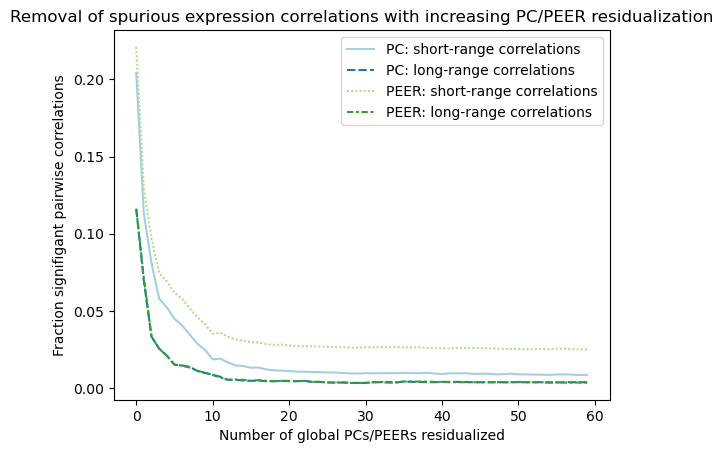

In [143]:
sns.lineplot(fraction_corr_sig_df, palette=sns.color_palette("Paired"), linestyle='-')
plt.xlabel('Number of global PCs/PEERs residualized')
plt.ylabel('Fraction signifigant pairwise correlations')

plt.title('Removal of spurious expression correlations with increasing PC/PEER residualization')